In [1]:
library(ggplot2)
library(reshape2)
library(cowplot)


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



### Data Input

In [2]:
md <- t(read.table("data/metadata.csv", sep="\t", header=1))
colnames(md) <- md["sample.id",]
mineral_otutable_abs <- read.table("data/otu_table_mineral_layer.tab", sep="\t")
organic_otutable_abs <- read.table("data/otu_table_organic_layer.tab", sep="\t")
mineral_otutable <- read.table("data/otu_table_mineral_layer_withinsample_relabundance.tab", sep="\t")
organic_otutable <- read.table("data/otu_table_organic_layer_withinsample_relabundance.tab", sep="\t")
mineral_otutable[,'X.OTU.ID'] <- mineral_otutable_abs[,'X.OTU.ID']
organic_otutable[,'X.OTU.ID'] <- organic_otutable_abs[,'X.OTU.ID']

Grab the top N OTUs from each component by absolute abundance

In [3]:
topn <- 10
topn_mineral <- names(
                sort(
                rowSums(
        mineral_otutable_abs[, colnames(md)[colnames(md) %in% colnames(mineral_otutable_abs)]]
    ), decreasing = TRUE))[0:topn]

topn_organic <- names(
                sort(
                rowSums(
        organic_otutable_abs[, colnames(md)[colnames(md) %in% colnames(organic_otutable_abs)]]
    ), decreasing = TRUE))[0:topn]

Melt the table for ggplot, and make sure the factors are set for the seasons so the order is right

In [4]:
melt_mineral <- melt(mineral_otutable[topn_mineral, 
                                      c("X.OTU.ID",colnames(md)[colnames(md)%in%colnames(mineral_otutable)])], 
                     id.var='X.OTU.ID')
colnames(melt_mineral) <- c("OTU", "Sample", "RelativeAbundance")
melt_organic <- melt(organic_otutable[topn_organic,
                                      c("X.OTU.ID",colnames(md)[colnames(md)%in%colnames(organic_otutable)])], 
                     id.var='X.OTU.ID')

colnames(melt_organic) <- c("OTU", "Sample", "RelativeAbundance")
for (mdcat in c("season_fine", "season_coarse", "julian_day", "sample_date")) {
    melt_organic[,mdcat] <- md[mdcat, match(melt_organic$Sample, colnames(md))]
    melt_mineral[,mdcat] <- md[mdcat, match(melt_mineral$Sample, colnames(md))]
}
melt_organic$OTU <- factor(melt_organic$OTU, levels=rev(organic_otutable[topn_organic, "X.OTU.ID"]))
melt_organic$season_fine <- factor(melt_organic$season_fine, 
                                   levels=c("Melt", "Early Spring", "Late Spring", 
                                            "Early Summer", "Mid Summer", "Autumn", "Winter"))
melt_organic$season_coarse <- factor(melt_organic$season_coarse, 
                                   levels=c("Melt", "Spring", "Summer", "Autumn", "Winter"),
                                   labels=c("Thaw", "Spring", "Summer", "Autumn", "Winter"))

melt_mineral$OTU <- factor(melt_mineral$OTU, levels=rev(mineral_otutable[topn_mineral, "X.OTU.ID"]))
melt_mineral$season_fine <- factor(melt_mineral$season_fine, 
                                   levels=c("Melt", "Early Spring", "Late Spring", 
                                            "Early Summer", "Mid Summer", "Autumn", "Winter"))
melt_mineral$season_coarse <- factor(melt_mineral$season_coarse, 
                                   levels=c("Melt", "Spring", "Summer", "Autumn", "Winter"),
                                   labels=c("Thaw", "Spring", "Summer", "Autumn", "Winter"))

Get the max and min for each OTU across coarse seasons

In [5]:
max_mineral <- aggregate(melt_mineral$RelativeAbundance, 
                         FUN=max, 
                         by=list(melt_mineral$OTU, melt_mineral$season_coarse))
colnames(max_mineral) <- c("OTU", "Season", "MinRelAbu")
min_mineral <- aggregate(melt_mineral$RelativeAbundance, 
                         FUN=min, 
                         by=list(melt_mineral$OTU, melt_mineral$season_coarse))
colnames(min_mineral) <- c("OTU", "Season", "MaxRelAbu")

max_organic <- aggregate(melt_organic$RelativeAbundance, 
                         FUN=max, 
                         by=list(melt_organic$OTU, melt_organic$season_coarse))
colnames(max_organic) <- c("OTU", "Season", "MinRelAbu")
min_organic <- aggregate(melt_organic$RelativeAbundance, 
                         FUN=min, 
                         by=list(melt_organic$OTU, melt_organic$season_coarse))
colnames(min_organic) <- c("OTU", "Season", "MaxRelAbu")

Get the max and min into the same table

In [6]:
merge_mineral <- merge(max_mineral, min_mineral, by.x=c("OTU", "Season"), by.y=c("OTU", "Season"))
merge_organic <- merge(max_organic, min_organic, by.x=c("OTU", "Season"), by.y=c("OTU", "Season"))

Make bubble plots: spoiler alert; it's bad data visualization. Let's try something else.

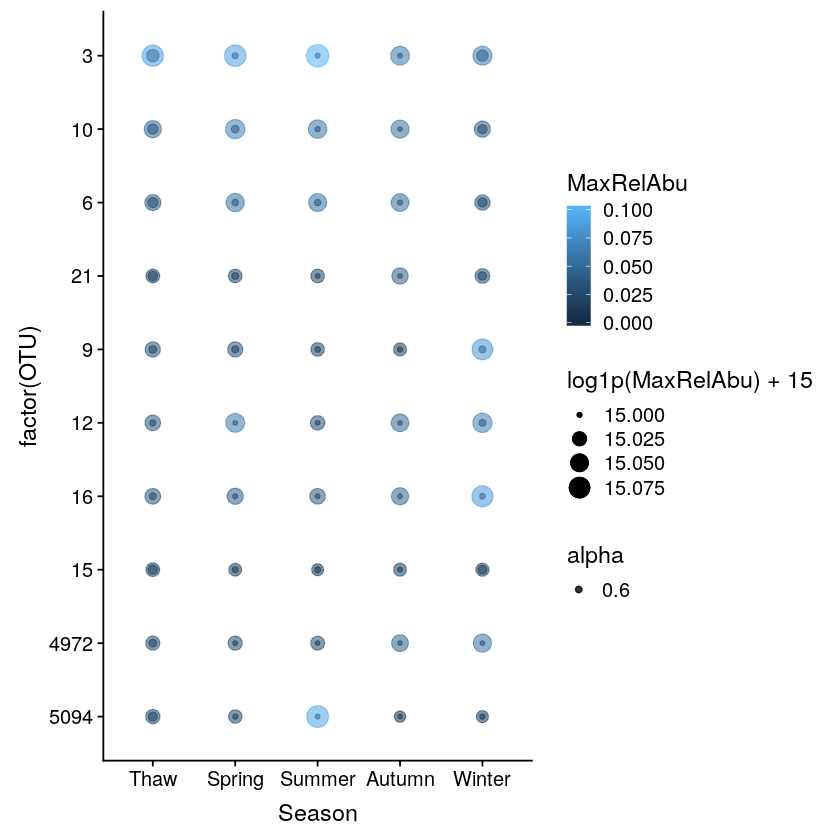

In [7]:
ggplot(merge_organic) + 
geom_point(aes(x=Season, y=factor(OTU), 
               size=log1p(MaxRelAbu)+15, 
               colour=MaxRelAbu,
               fill=MaxRelAbu,
               alpha=0.6,
               shape=19)) +
geom_point(aes(x=Season, y=factor(OTU), 
               size=log1p(MinRelAbu)+15, 
               colour=MinRelAbu,
               fill=MinRelAbu,
               alpha=0.6,
               shape=19)) +
scale_shape_identity() +
scale_y_discrete()

For each component, get the mean and standard error across coarse season

In [8]:
standard.error <- function(x) {
    sqrt(var(x)/length(x))
}
sb_organic_mean <- aggregate(melt_organic$RelativeAbundance, FUN=mean, by=list(melt_organic$season_coarse, melt_organic$OTU))
colnames(sb_organic_mean) <- c("Season", "OTU", "MeanRelativeAbundance")
sb_mineral_mean <- aggregate(melt_mineral$RelativeAbundance, FUN=mean, by=list(melt_mineral$season_coarse, melt_mineral$OTU))
colnames(sb_mineral_mean) <- c("Season", "OTU", "MeanRelativeAbundance")

sb_organic_sd <- aggregate(melt_organic$RelativeAbundance, FUN=standard.error, by=list(melt_organic$season_coarse, melt_organic$OTU))
colnames(sb_organic_sd) <- c("Season", "OTU", "AbundanceSD")
sb_mineral_sd <- aggregate(melt_mineral$RelativeAbundance, FUN=standard.error, by=list(melt_mineral$season_coarse, melt_mineral$OTU))
colnames(sb_mineral_sd) <- c("Season", "OTU", "AbundanceSD")

sb_organic <- merge(sb_organic_mean, sb_organic_sd)
sb_mineral <- merge(sb_mineral_mean, sb_mineral_sd)
sb_organic$Classification <- as.character(organic_otutable[sb_organic$OTU, 'Consensus.Lineage'])
sb_mineral$Classification <- as.character(mineral_otutable[sb_mineral$OTU, 'Consensus.Lineage'])
sb_organic$OTU <- factor(sb_organic$OTU, levels=organic_otutable[topn_organic, "X.OTU.ID"])
sb_mineral$OTU <- factor(sb_mineral$OTU, levels=mineral_otutable[topn_mineral, "X.OTU.ID"])

Make a line plot instead, uncomment if you want errorbars but they cause excessive visual clutter and aren't necessary for the narrative we're using the figure for

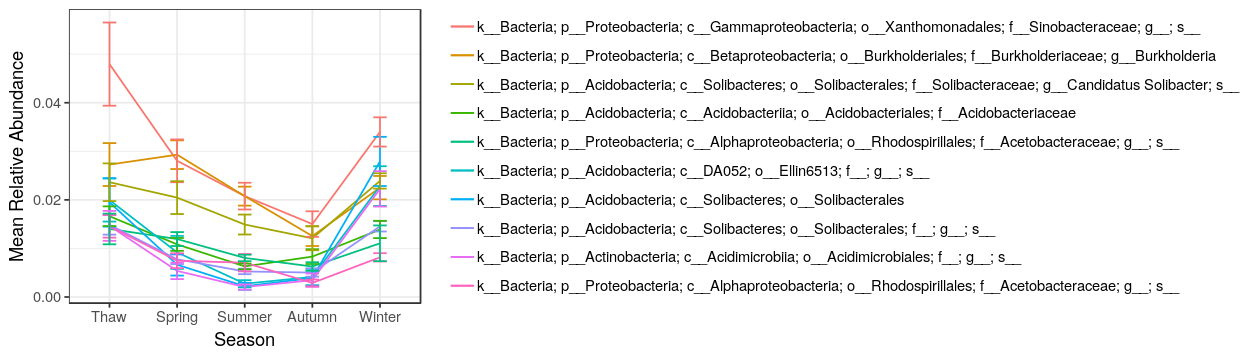

In [9]:
options(repr.plot.width=10.5, repr.plot.height=3)
#pdf("organic_by_season.pdf", height=3, width=10.5)
p1 <- ggplot(sb_organic) + 
geom_line(aes(y=MeanRelativeAbundance, 
              x = Season, 
              group=OTU, 
              colour=OTU)) +
geom_errorbar(aes(x = Season,
                  ymin=MeanRelativeAbundance+AbundanceSD, 
                  ymax=MeanRelativeAbundance-AbundanceSD,
                  colour=OTU), width=0.2) +
theme_bw() + scale_colour_discrete(labels=sb_organic$Classification[1:10]) + theme(legend.title=element_blank(), legend.position="right") +
guides(colour=guide_legend(nrow=topn,byrow=TRUE)) + ylab("Mean Relative Abundance")
p1

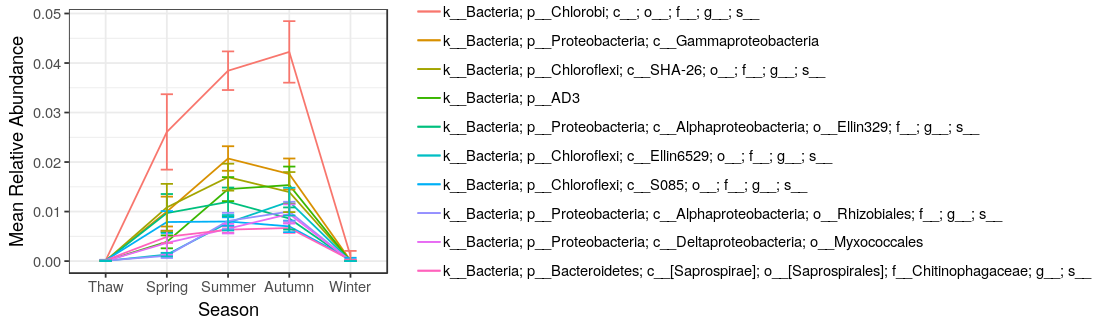

In [10]:
options(repr.plot.width=9.25, repr.plot.height=2.75)
#pdf("mineral_by_season.pdf", height=3, width=10.5)
p2 <- ggplot(sb_mineral) + 
geom_line(aes(y=MeanRelativeAbundance, 
              x = Season, 
              group=OTU, 
              colour=OTU)) +
geom_errorbar(aes(x = Season,
                  ymin=MeanRelativeAbundance+AbundanceSD, 
                  ymax=MeanRelativeAbundance-AbundanceSD,
                  colour=factor(OTU)), width=0.2) +
theme_bw() + scale_colour_discrete(labels=sb_mineral$Classification[1:10])+ theme(legend.title=element_blank(), legend.position="right") +
guides(colour=guide_legend(nrow=topn,byrow=TRUE)) + ylab("Mean Relative Abundance")
p2

In [13]:
pdf("combined_temporal.pdf", height=7, width=11)
options(repr.plot.height=6, repr.plot.width=11)
plot_grid(p1, p2, ncol=1, labels=c("A", "B"), align='v')
dev.off()

png 
  2